In [1]:
from ndll.pipeline import Pipeline
import ndll.ops as ops
import ndll.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt

db_folder = "/data/train-lmdb-256x256"

class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, pipelined = True, async = True):
        super(HybridPipe, self).__init__(batch_size, num_threads, device_id, seed = 12, exec_pipelined=pipelined, exec_async=async)
        self.input = ops.CaffeReader(path = db_folder, random_shuffle = True)
        self.huffman = ops.HuffmanDecoder()
        self.idct = ops.DCTQuantInv(device = "gpu", output_type = types.RGB)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            output_layout = types.NHWC,
                                            random_crop = True,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [128., 128., 128.],
                                            std = [1., 1., 1.])
        self.jitter = ops.Jitter(device = "gpu")
        self.water = ops.Water(device = "gpu")
        self.sphere = ops.Sphere(device = "gpu")
        self.copy = ops.Copy(device="gpu")
        self.iter = 0

    def define_graph(self):
        self.jpegs, self.labels = self.input()
        dct_coeff, jpeg_meta = self.huffman(self.jpegs)
        images = self.idct(dct_coeff.gpu(), jpeg_meta)
        outputs = self.cmnp([images, images, images, images])
        outputs[1] = self.jitter(outputs[1])
        outputs[2] = self.water(outputs[2])
        outputs[3] = self.sphere(outputs[3])
        return [self.labels] + outputs

    def iter_setup(self):
        pass

In [2]:
pipe = HybridPipe(batch_size=128, num_threads=2, device_id = 0, pipelined = True, async = True)
pipe.build()

OpSpec for CaffeReader:
  Inputs:
  Outputs:
  Arguments:
    random_shuffle: True
    path: /data/train-lmdb-256x256

2
OpSpec for HuffmanDecoder:
  Inputs:
    CaffeReader_id_0_output_0_cpu
  Outputs:
  Arguments:

2
OpSpec for DCTQuantInv:
  Inputs:
    HuffmanDecoder_id_1_output_0_gpu
    HuffmanDecoder_id_1_output_1_cpu
  Outputs:
  Arguments:
    output_type: 0
    device: gpu

1
OpSpec for CropMirrorNormalize:
  Inputs:
    DCTQuantInv_id_2_output_0_gpu
    DCTQuantInv_id_2_output_0_gpu
    DCTQuantInv_id_2_output_0_gpu
    DCTQuantInv_id_2_output_0_gpu
  Outputs:
  Arguments:
    num_input_sets: 4
    mean: [128.000000, 128.000000, 128.000000, ]
    random_crop: True
    output_dtype: 5
    std: [1.000000, 1.000000, 1.000000, ]
    device: gpu
    output_layout: 1
    image_type: 0
    crop: [224, 224, ]

4
OpSpec for Jitter:
  Inputs:
    CropMirrorNormalize_id_3_output_1_gpu
  Outputs:
  Arguments:
    device: gpu

1
OpSpec for Water:
  Inputs:
    CropMirrorNormalize_id_3_ou

In [3]:
pipe_out = pipe.run()

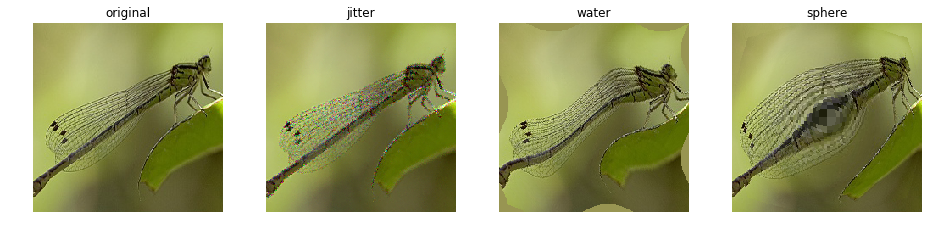

In [4]:
n = 114
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec
len_outputs = len(pipe_out) - 1
augmentations = ["original",
                 "jitter",
                 "water",
                 "sphere"]
fig = plt.figure(figsize = (16,16))
columns = 4
rows = 4
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].asCPU()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw+128)/255.0)
